## Downloading Data

In [1]:
! pip install kaggle

In [2]:
mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [4]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
! kaggle datasets download cashutosh/gender-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset
License(s): other
 99% 268M/269M [00:11<00:00, 24.3MB/s]
100% 269M/269M [00:11<00:00, 24.8MB/s]


In [6]:
! unzip -q /content/gender-classification-dataset.zip

## Working with the dataset

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os

In [8]:
data_transforms = {
    'Training': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
data_dir = '/content'  # Replace with the path to your dataset

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['Training', 'Validation']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['Training', 'Validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Validation']}
class_names = image_datasets['Training'].classes

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Binary classification

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


In [11]:
def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        for phase in ['Training', 'Validation']:
            if phase == 'Training':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

    return model

model = train_model(model, criterion, optimizer, num_epochs=15)

Epoch 0/14
----------
Training Loss: 0.1429 Acc: 0.9453
Validation Loss: 0.0761 Acc: 0.9719

Epoch 1/14
----------
Training Loss: 0.0895 Acc: 0.9682
Validation Loss: 0.0731 Acc: 0.9717

Epoch 2/14
----------
Training Loss: 0.0727 Acc: 0.9738
Validation Loss: 0.0655 Acc: 0.9754

Epoch 3/14
----------
Training Loss: 0.0587 Acc: 0.9794
Validation Loss: 0.0721 Acc: 0.9741

Epoch 4/14
----------
Training Loss: 0.0476 Acc: 0.9834
Validation Loss: 0.0752 Acc: 0.9730

Epoch 5/14
----------
Training Loss: 0.0333 Acc: 0.9887
Validation Loss: 0.0761 Acc: 0.9745

Epoch 6/14
----------
Training Loss: 0.0260 Acc: 0.9911
Validation Loss: 0.0846 Acc: 0.9712

Epoch 7/14
----------
Training Loss: 0.0197 Acc: 0.9929
Validation Loss: 0.0923 Acc: 0.9711

Epoch 8/14
----------
Training Loss: 0.0137 Acc: 0.9954
Validation Loss: 0.0983 Acc: 0.9745

Epoch 9/14
----------
Training Loss: 0.0114 Acc: 0.9961
Validation Loss: 0.1000 Acc: 0.9712

Epoch 10/14
----------
Training Loss: 0.0096 Acc: 0.9971
Validation Lo

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
torch.save(model.state_dict(), '/content/drive/MyDrive/gender_classification_model.pth')

In [15]:
model.load_state_dict(torch.load('/content/drive/MyDrive/gender_classification_model.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

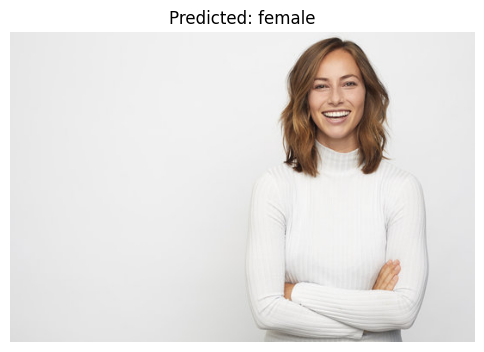

In [18]:
from PIL import Image
import matplotlib.pyplot as plt

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def load_image(image_path):
    image = Image.open(image_path)
    image = preprocess(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Replace 'path/to/your/image.jpg' with the actual image path
image_path = '/content/drive/MyDrive/female_stock_photo.jpg'
image = load_image(image_path)
image = image.to(device)

# Run inference
with torch.no_grad():
    outputs = model(image)
    _, preds = torch.max(outputs, 1)

# Get the class names
class_names = ['female', 'male']
prediction = class_names[preds[0]]

# Load the original image for visualization
original_image = Image.open(image_path)

# Plot the image and prediction
plt.figure(figsize=(6,6))
plt.imshow(original_image)
plt.title(f'Predicted: {prediction}')
plt.axis('off')
plt.show()